In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
ex4data = scipy.io.loadmat("./ex4data1.mat")
initX = ex4data['X']
y = ex4data['y'][:,0]
#y[y==10] = 0
m, n = initX.shape
m, n
X = np.hstack((np.ones((m,1)), initX))
weights = scipy.io.loadmat('./ex4weights.mat')
Theta1 = weights['Theta1']
Theta2 = weights['Theta2']
input_layer_size = Theta1.shape[1] - 1
hidden_layer_size = Theta2.shape[1] - 1
num_labels = Theta2.shape[0]

In [14]:
import matplotlib.image as mpimg

def displayData(X):
    fig, axis = plt.subplots(10,10,figsize=(8,8))
    for i in range(10):
        for j in range(10):
            axis[i,j].imshow(X[i*10+j,:].reshape(20,20,order="F"), cmap="hot")
            axis[i,j].axis("off")

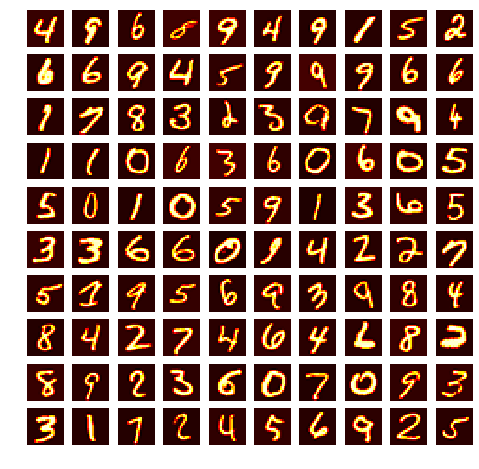

In [15]:
# Randomly select 100 data points to display
randIndices = np.random.permutation(m)
sel = initX[randIndices[:100],:]

displayData(sel)

In [75]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_gradient(x):
    return sigmoid(x) * (1.0 - sigmoid(x))

def rand_initialize_weights(L_in, L_out):
    eps = 0.12
    return np.random.uniform(-eps, eps, (L_out, 1 + L_in))

def nn_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_):
    boundary = (input_layer_size + 1) * hidden_layer_size
    Theta1 = nn_params[:boundary].reshape((hidden_layer_size, input_layer_size + 1))
    Theta2 = nn_params[boundary:].reshape((num_labels, hidden_layer_size + 1))
    #Theta1_grad = np.zeros_like(Theta1)
    #Theta2_grad = np.zeros_like(Theta2)
    m = X.shape[0]

    y = np.reshape(y, (np.shape(y)[0],1))
    yMatrix = 1 * (np.arange(1,num_labels+1) == y)    
    
    a1 = X
    z2 = a1.dot(Theta1.T)
    
    a2 = np.hstack((np.ones((z2.shape[0], 1)), sigmoid(z2)))
    z3 = a2.dot(Theta2.T)

    a3 = sigmoid(z3)

    #cost function
    J = -np.sum(yMatrix * np.log(a3) + (1 - yMatrix) * np.log(1.0 - a3)) / m
    
    # regularization
    reg = lambda_ / (2 * m) * (np.sum(Theta1[:,1:]**2) + np.sum(Theta2[:,1:]**2))
    
    return J + reg, 0
    
#     possible_labels = np.arange(1, num_labels + 1)
#     cost = 0.0
#     for i in range(m):
#         a1 = X[i, :]
#         a2 = sigmoid(Theta1.dot(a1))
#         a2 = np.concatenate((np.ones(1), a2))
#         h = a3 = sigmoid(Theta2.dot(a2))
#         y_vec = np.vectorize(int)(possible_labels == y[i])
#         cost += sum(-y_vec * np.log(h) - (1.0 - y_vec) * np.log(1.0 - h))
#         # backprop
#         delta3 = a3 - y_vec
#         Theta2_grad += np.outer(delta3, a2)
#         delta2 = Theta2.T.dot(delta3) * a2 * (1 - a2)
#         Theta1_grad += np.outer(delta2[1:], a1)
#     cost = cost / m
#     Theta1_grad /= m
#     Theta2_grad /= m
#     # regularization
#     reg_cost = (lambda_ / (2.0 * m)) * (np.sum(Theta1[:, 1:] ** 2) + np.sum(Theta2[:, 1:] ** 2))
#     Theta1_grad += (lambda_ / m) * np.concatenate((np.zeros((Theta1.shape[0], 1)), Theta1[:, 1:]), axis=1)
#     Theta2_grad += (lambda_ / m) * np.concatenate((np.zeros((Theta2.shape[0], 1)), Theta2[:, 1:]), axis=1)
#     gradient = np.concatenate((Theta1_grad.flatten(), Theta2_grad.flatten()))
#     return cost + reg_cost, gradient

In [73]:
nn_params = np.concatenate((Theta1.flatten(), Theta2.flatten()))
# feed-forward
cost, grad = nn_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, 0)
print('Cost at parameters (loaded from ex4weights): %f' % cost)
print('(this value should be about 0.287629)')
# feed-forward with regularization
print('Checking Cost Function (w/ Regularization) ...')
cost, grad = nn_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, 1)
print('Cost at parameters (loaded from ex4weights): %f' % cost)
print('(this value should be about 0.383770)')

Cost at parameters (loaded from ex4weights): 0.287629
(this value should be about 0.287629)
Checking Cost Function (w/ Regularization) ...
Cost at parameters (loaded from ex4weights): 0.383770
(this value should be about 0.383770)


In [83]:
initial_Theta1 = rand_initialize_weights(input_layer_size, hidden_layer_size);
initial_Theta2 = rand_initialize_weights(hidden_layer_size, num_labels);

print(initial_Theta1.shape)
print(initial_Theta2.shape)

# Unroll parameters
initial_nn_params = np.concatenate((initial_Theta1.flatten(), initial_Theta2.flatten()))

(25, 401)
(10, 26)
